In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    
    return y.flatten()

def generate_data_set(dataset_size, preamble_length, data_length, channel_length, SNR):
    input_data_bits = np.random.randint(0,2,(dataset_size, data_length)) 
    input_data_constellations = input_data_bits * 2 - 1
        
    preambles = np.random.randint(0, 2, (dataset_size, preamble_length))
    convolved_preambles = []
    convolved_data_constellations = []
    
    for i in range(dataset_size):
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps)>=1:
            channel_taps = channel_taps / sum(channel_taps)
        preamble_conv = add_awgn_noise(sig.convolve(preambles[i], channel_taps, mode='same'), SNR)
        convolved_preambles.append(preamble_conv)
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellations[i], channel_taps, mode='same'), SNR)
        convolved_data_constellations.append(constellation_convolved)
    X = np.hstack([preambles, np.array(convolved_preambles), np.array(convolved_data_constellations)])
    Y = input_data_constellations
    return X, Y

X, Y = generate_data_set(10000, 20, 40, 2, 10)

In [3]:
print(X.shape, Y.shape)

(10000, 80) (10000, 40)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
def create_model(input_layer_dim, hidden_layer_dim, input_dim, output_dim):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden_layer_dim, activation='relu'))
    model.add(Dense(output_dim, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

model = create_model(300, 300, X_train.shape[1], Y_train.shape[1])
model.fit(X_train, Y_train, epochs=100)
predictions = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(predictions, Y_test)
mabse = mean_absolute_error(predictions, Y_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

Epoch 1/100
8000/8000 [==============================] - 0s - loss: 0.4936 - mean_squared_error: 0.4936     
Epoch 2/100
8000/8000 [==============================] - 0s - loss: 0.3449 - mean_squared_error: 0.3449     
Epoch 3/100
8000/8000 [==============================] - 0s - loss: 0.3305 - mean_squared_error: 0.3305     
Epoch 4/100
8000/8000 [==============================] - 0s - loss: 0.3219 - mean_squared_error: 0.3219     
Epoch 5/100
8000/8000 [==============================] - 0s - loss: 0.3123 - mean_squared_error: 0.3123     
Epoch 6/100
8000/8000 [==============================] - 0s - loss: 0.3055 - mean_squared_error: 0.3055     
Epoch 7/100
8000/8000 [==============================] - 0s - loss: 0.2978 - mean_squared_error: 0.2978     
Epoch 8/100
8000/8000 [==============================] - 0s - loss: 0.2912 - mean_squared_error: 0.2912     
Epoch 9/100
8000/8000 [==============================] - 0s - loss: 0.2846 - mean_squared_error: 0.2846     
Epoch 10/100
8000/8

8000/8000 [==============================] - 0s - loss: 0.0648 - mean_squared_error: 0.0648     
Epoch 76/100
8000/8000 [==============================] - 0s - loss: 0.0626 - mean_squared_error: 0.0626     
Epoch 77/100
8000/8000 [==============================] - 0s - loss: 0.0623 - mean_squared_error: 0.0623     
Epoch 78/100
8000/8000 [==============================] - 0s - loss: 0.0610 - mean_squared_error: 0.0610     
Epoch 79/100
8000/8000 [==============================] - 0s - loss: 0.0626 - mean_squared_error: 0.0626     
Epoch 80/100
8000/8000 [==============================] - 0s - loss: 0.0622 - mean_squared_error: 0.0622     
Epoch 81/100
8000/8000 [==============================] - 0s - loss: 0.0591 - mean_squared_error: 0.0591     
Epoch 82/100
8000/8000 [==============================] - 0s - loss: 0.0600 - mean_squared_error: 0.0600     
Epoch 83/100
8000/8000 [==============================] - 0s - loss: 0.0586 - mean_squared_error: 0.0586     
Epoch 84/100
8000/8000 

In [5]:
print(predictions)

[[-1.         -0.964104    0.99977    ... -1.         -1.
  -0.99993986]
 [-1.          1.          1.         ... -1.         -1.
  -0.999523  ]
 [-0.9999333   1.          1.         ...  1.          0.9999468
  -1.        ]
 ...
 [-1.         -0.45595777  1.         ...  0.9998585   1.
  -0.99995536]
 [ 1.          1.         -0.9999999  ...  0.9999931   1.
   0.31632844]
 [ 0.9999934  -0.9886104  -1.         ... -0.35461572  1.
   1.        ]]


In [6]:
print(Y_test)

[[-1 -1  1 ... -1 -1 -1]
 [-1  1  1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1  1  1 ...  1  1 -1]
 [ 1  1 -1 ...  1  1  1]
 [ 1 -1 -1 ...  1  1  1]]


In [7]:
rounded_predictions = np.where(predictions > 0, 1, -1)
rounded_predictions

array([[-1, -1,  1, ..., -1, -1, -1],
       [-1,  1,  1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1, -1,  1, ...,  1,  1, -1],
       [ 1,  1, -1, ...,  1,  1,  1],
       [ 1, -1, -1, ..., -1,  1,  1]])

In [8]:
def calc_accuracy(original, predictions):
    return np.sum(original == predictions) / (original.shape[0] * original.shape[1])
calc_accuracy(Y_test, rounded_predictions)

0.8743625

In [9]:
def generate_channel_data_set(dataset_size, data_length, channel_length, SNR):
    input_data_bits = np.random.randint(0,2,(dataset_size, data_length)) 
    input_data_constellations = input_data_bits * 2 - 1
    
    convolved_data_constellations = []
    channels= []
    
    for i in range(dataset_size):
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps)>=1:
            channel_taps = channel_taps / sum(channel_taps)
        channels.append(channel_taps)
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellations[i], channel_taps, mode='same'), SNR)
        convolved_data_constellations.append(constellation_convolved)
    X = np.hstack([np.array(channels), np.array(convolved_data_constellations)])
    Y = input_data_constellations
    return X, Y

X, Y = generate_channel_data_set(10000, 40, 2, 10)
print(X.shape, Y.shape)
print(X)
print(Y)

(10000, 42) (10000, 40)
[[ 0.02480375  0.87786724  0.42363619 ...  0.69840526  1.00192467
   0.81512052]
 [ 0.28461326  0.41015693 -0.48605192 ...  0.33533935 -0.51485916
  -0.66148329]
 [ 0.50815963  0.3191266   0.68153568 ...  0.31422932  0.38569871
   0.9785387 ]
 ...
 [ 0.40532169  0.19955261 -0.52453031 ... -0.84053881  0.20772992
  -0.20105906]
 [ 0.61171852  0.22170766  0.82467143 ... -0.31189178 -0.66584868
   0.37340235]
 [ 0.23507199  0.38222523 -0.23465891 ...  0.29236833  0.30861638
  -0.43417995]]
[[-1 -1  1 ...  1  1 -1]
 [-1 -1  1 ... -1 -1 -1]
 [ 1  1  1 ...  1  1  1]
 ...
 [-1  1 -1 ... -1  1 -1]
 [ 1 -1  1 ... -1 -1  1]
 [-1 -1 -1 ...  1 -1 -1]]


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
model = create_model(300, 300, X_train.shape[1], Y_train.shape[1])
model.fit(X_train, Y_train, epochs=100)
predictions = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(predictions, Y_test)
mabse = mean_absolute_error(predictions, Y_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))
rounded_predictions = np.where(predictions > 0, 1, -1)
calc_accuracy(Y_test, rounded_predictions)

Epoch 1/100
8000/8000 [==============================] - 0s - loss: 0.4722 - mean_squared_error: 0.4722     
Epoch 2/100
8000/8000 [==============================] - 0s - loss: 0.3289 - mean_squared_error: 0.3289     
Epoch 3/100
8000/8000 [==============================] - 0s - loss: 0.3110 - mean_squared_error: 0.3110     
Epoch 4/100
8000/8000 [==============================] - 0s - loss: 0.2931 - mean_squared_error: 0.2931     
Epoch 5/100
8000/8000 [==============================] - 0s - loss: 0.2634 - mean_squared_error: 0.2634     
Epoch 6/100
8000/8000 [==============================] - 0s - loss: 0.2242 - mean_squared_error: 0.2242     
Epoch 7/100
8000/8000 [==============================] - 0s - loss: 0.1825 - mean_squared_error: 0.1825     
Epoch 8/100
8000/8000 [==============================] - 0s - loss: 0.1451 - mean_squared_error: 0.1451     
Epoch 9/100
8000/8000 [==============================] - 0s - loss: 0.1187 - mean_squared_error: 0.1187     
Epoch 10/100
8000/8

8000/8000 [==============================] - 0s - loss: 0.0116 - mean_squared_error: 0.0116     
Epoch 76/100
8000/8000 [==============================] - 0s - loss: 0.0134 - mean_squared_error: 0.0134     
Epoch 77/100
8000/8000 [==============================] - 0s - loss: 0.0125 - mean_squared_error: 0.0125     
Epoch 78/100
8000/8000 [==============================] - 0s - loss: 0.0128 - mean_squared_error: 0.0128     
Epoch 79/100
8000/8000 [==============================] - 0s - loss: 0.0130 - mean_squared_error: 0.0130     
Epoch 80/100
8000/8000 [==============================] - 0s - loss: 0.0119 - mean_squared_error: 0.0119     
Epoch 81/100
8000/8000 [==============================] - 0s - loss: 0.0099 - mean_squared_error: 0.0099     
Epoch 82/100
8000/8000 [==============================] - 0s - loss: 0.0107 - mean_squared_error: 0.0107     
Epoch 83/100
8000/8000 [==============================] - 0s - loss: 0.0112 - mean_squared_error: 0.0112     
Epoch 84/100
8000/8000 

0.963425

In [11]:
def generate_preamble_datasets(dataset_size, preamble_length, channel_length, SNR):
        
    preambles = np.random.randint(0, 2, (dataset_size, preamble_length))
    convolved_preambles = []
    channels = []
    for i in range(dataset_size):
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps)>=1:
            channel_taps = channel_taps / sum(channel_taps)
            
        channels.append(channel_taps)
        preamble_conv = add_awgn_noise(sig.convolve(preambles[i], channel_taps, mode='same'), SNR)
        convolved_preambles.append(preamble_conv)

    X = np.hstack([preambles, np.array(convolved_preambles)])
    Y = np.array(channels)
    return X, Y

X, Y = generate_preamble_datasets(10000, 20, 2, 10)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
model = create_model(300, 300, X_train.shape[1], Y_train.shape[1])
model.fit(X_train, Y_train, epochs=100)
predictions = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(predictions, Y_test)
mabse = mean_absolute_error(predictions, Y_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

Epoch 1/100
8000/8000 [==============================] - 1s - loss: 0.0231 - mean_squared_error: 0.0231     
Epoch 2/100
8000/8000 [==============================] - 0s - loss: 0.0079 - mean_squared_error: 0.0079     
Epoch 3/100
8000/8000 [==============================] - 0s - loss: 0.0061 - mean_squared_error: 0.0061     
Epoch 4/100
8000/8000 [==============================] - 0s - loss: 0.0052 - mean_squared_error: 0.0052     
Epoch 5/100
8000/8000 [==============================] - 0s - loss: 0.0046 - mean_squared_error: 0.0046     
Epoch 6/100
8000/8000 [==============================] - 0s - loss: 0.0040 - mean_squared_error: 0.0040     
Epoch 7/100
8000/8000 [==============================] - 0s - loss: 0.0035 - mean_squared_error: 0.0035     
Epoch 8/100
8000/8000 [==============================] - 0s - loss: 0.0033 - mean_squared_error: 0.0033     
Epoch 9/100
8000/8000 [==============================] - 0s - loss: 0.0030 - mean_squared_error: 0.0030     
Epoch 10/100
8000/8

8000/8000 [==============================] - 0s - loss: 4.8633e-04 - mean_squared_error: 4.8633e-04     
Epoch 73/100
8000/8000 [==============================] - 0s - loss: 4.5724e-04 - mean_squared_error: 4.5724e-04     
Epoch 74/100
8000/8000 [==============================] - 0s - loss: 4.9316e-04 - mean_squared_error: 4.9316e-04     
Epoch 75/100
8000/8000 [==============================] - 0s - loss: 4.6844e-04 - mean_squared_error: 4.6844e-04     
Epoch 76/100
8000/8000 [==============================] - 0s - loss: 4.6410e-04 - mean_squared_error: 4.6410e-04     
Epoch 77/100
8000/8000 [==============================] - 0s - loss: 4.7005e-04 - mean_squared_error: 4.7005e-04     
Epoch 78/100
8000/8000 [==============================] - 0s - loss: 4.7612e-04 - mean_squared_error: 4.7612e-04     
Epoch 79/100
8000/8000 [==============================] - 0s - loss: 4.7417e-04 - mean_squared_error: 4.7417e-04     
Epoch 80/100
8000/8000 [==============================] - 0s - loss: 

In [13]:
# combine previous two neural networks
def generate_combined_dataset(dataset_size, preamble_length, data_length, channel_length, SNR):
    input_data_bits = np.random.randint(0,2,(dataset_size, data_length)) 
    input_data_constellations = input_data_bits * 2 - 1
        
    preambles = np.random.randint(0, 2, (dataset_size, preamble_length))
    convolved_preambles = []
    convolved_data_constellations = []
    channels = []
    for i in range(dataset_size):
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps)>=1:
            channel_taps = channel_taps / sum(channel_taps)
            
        channels.append(channel_taps)
        preamble_conv = add_awgn_noise(sig.convolve(preambles[i], channel_taps, mode='same'), SNR)
        convolved_preambles.append(preamble_conv)
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellations[i], channel_taps, mode='full'), SNR)
        convolved_data_constellations.append(constellation_convolved)
    X = np.hstack([preambles, np.array(convolved_preambles), np.array(convolved_data_constellations)])
    Y = np.hstack([np.array(channels), input_data_constellations])
    return X, Y

preamble_length = 20
dataset_size = 10000
data_length = 40
channel_length = 2
SNR= 10
X, Y = generate_combined_dataset(dataset_size, preamble_length, data_length, channel_length, SNR)

print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# print(X)
# print(Y)
preamble_X_train, preamble_X_test = X_train[:, :preamble_length * 2],  X_test[:, :preamble_length * 2]
channel_Y_train, channel_Y_test = Y_train[:, :channel_length], Y_test[:, :channel_length]
print(preamble_X_train.shape, preamble_X_test.shape)
print(channel_Y_train.shape, channel_Y_test.shape)
model_1 = create_model(300, 300, preamble_X_train.shape[1], channel_Y_train.shape[1])
model_1.fit(preamble_X_train, channel_Y_train, epochs=100)

# predictions = model.predict(preamble_X_test)
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# mse = mean_squared_error(predictions, channel_Y_test)
# mabse = mean_absolute_error(predictions, channel_Y_test)
# print('Mean Squared Error: {0}'.format(mse))
# print('Mean Absolute Error: {0}'.format(mabse))
channel_X_train = model_1.predict(preamble_X_train)
channel_X_test = model_1.predict(preamble_X_test)
data_convolved_X_train, data_convolved_X_test = X_train[:, preamble_length * 2:],  X_test[:, preamble_length * 2:]
new_X_train = np.hstack([channel_X_train, data_convolved_X_train])
new_X_test = np.hstack([channel_X_test, data_convolved_X_test])
new_Y_train, new_Y_test = Y_train[:, channel_length:], Y_test[:, channel_length:]
print(new_X_train.shape, new_X_test.shape, new_Y_train.shape, new_Y_train.shape)

model_2 = create_model(300, 300, new_X_train.shape[1], new_Y_train.shape[1])
model_2.fit(new_X_train, new_Y_train, epochs=100)
predictions = model_2.predict(new_X_test)
mse = mean_squared_error(predictions, new_Y_test)
mabse = mean_absolute_error(predictions, new_Y_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))
rounded_predictions = np.where(predictions > 0, 1, -1)
calc_accuracy(new_Y_test, rounded_predictions)



(10000, 81) (10000, 42)
(8000, 40) (2000, 40)
(8000, 2) (2000, 2)
Epoch 1/100
8000/8000 [==============================] - 0s - loss: 0.0296 - mean_squared_error: 0.0296     
Epoch 2/100
8000/8000 [==============================] - 0s - loss: 0.0088 - mean_squared_error: 0.0088     
Epoch 3/100
8000/8000 [==============================] - 0s - loss: 0.0066 - mean_squared_error: 0.0066     
Epoch 4/100
8000/8000 [==============================] - 0s - loss: 0.0055 - mean_squared_error: 0.0055     
Epoch 5/100
8000/8000 [==============================] - 0s - loss: 0.0049 - mean_squared_error: 0.0049     
Epoch 6/100
8000/8000 [==============================] - 0s - loss: 0.0044 - mean_squared_error: 0.0044     
Epoch 7/100
8000/8000 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039     
Epoch 8/100
8000/8000 [==============================] - 0s - loss: 0.0036 - mean_squared_error: 0.0036     
Epoch 9/100
8000/8000 [==============================] - 0s - 

8000/8000 [==============================] - 0s - loss: 4.9578e-04 - mean_squared_error: 4.9578e-04     
Epoch 72/100
8000/8000 [==============================] - 0s - loss: 4.7470e-04 - mean_squared_error: 4.7470e-04     
Epoch 73/100
8000/8000 [==============================] - 0s - loss: 4.6300e-04 - mean_squared_error: 4.6300e-04     
Epoch 74/100
8000/8000 [==============================] - 0s - loss: 4.2944e-04 - mean_squared_error: 4.2944e-04     
Epoch 75/100
8000/8000 [==============================] - 0s - loss: 4.1853e-04 - mean_squared_error: 4.1853e-04     
Epoch 76/100
8000/8000 [==============================] - 0s - loss: 5.0429e-04 - mean_squared_error: 5.0429e-04     
Epoch 77/100
8000/8000 [==============================] - 0s - loss: 5.6286e-04 - mean_squared_error: 5.6286e-04     
Epoch 78/100
8000/8000 [==============================] - 0s - loss: 5.2368e-04 - mean_squared_error: 5.2368e-04     
Epoch 79/100
8000/8000 [==============================] - 0s - loss: 

8000/8000 [==============================] - 0s - loss: 0.0168 - mean_squared_error: 0.0168     
Epoch 44/100
8000/8000 [==============================] - 0s - loss: 0.0158 - mean_squared_error: 0.0158     
Epoch 45/100
8000/8000 [==============================] - 0s - loss: 0.0143 - mean_squared_error: 0.0143     
Epoch 46/100
8000/8000 [==============================] - 0s - loss: 0.0140 - mean_squared_error: 0.0140     
Epoch 47/100
8000/8000 [==============================] - 0s - loss: 0.0134 - mean_squared_error: 0.0134     
Epoch 48/100
8000/8000 [==============================] - 0s - loss: 0.0133 - mean_squared_error: 0.0133     
Epoch 49/100
8000/8000 [==============================] - 0s - loss: 0.0132 - mean_squared_error: 0.0132     
Epoch 50/100
8000/8000 [==============================] - 0s - loss: 0.0145 - mean_squared_error: 0.0145     
Epoch 51/100
8000/8000 [==============================] - 0s - loss: 0.0147 - mean_squared_error: 0.0147     
Epoch 52/100
8000/8000 

0.9598625

In [14]:
def zfEqualize(channel_output, channel):
    # make sure have same fft length 
    # we get the correct number of terms as this is like a circular convolution so the last packet is garbage
    freq_domain = np.fft.fft(channel_output, len(channel_output))/np.fft.fft(channel, len(channel_output))
    return np.fft.ifft(freq_domain)[0:len(channel_output) - len(channel) + 1] # check 

# Count number of symbols that are off
def calc_accuracy(original, predictions):
    return np.sum(original == predictions) / (original.shape[0] * original.shape[1])

# Adds complex gaussian noise to inputted signal 
def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    
    return y.flatten()

def test_zf_accuracy(channel_outputs, true_data, channels, data_length, channel_length):
    # make modulator and message size
    predictions = []
    print(channel_outputs.shape)
    for i in range(channel_outputs.shape[0]):
        equalized_result = zfEqualize(channel_outputs[i], channels[i])
        real_component = np.real(equalized_result)
        rounded_predictions = np.where(real_component > 0, 1, -1)
        predictions.append(rounded_predictions)
    return calc_accuracy(np.array(predictions), true_data)
        
accuracy = test_zf_accuracy(data_convolved_X_test, new_Y_test, channel_Y_test, 40, 2)

print(accuracy)
#     constellation = 4
#     QAMModem = cp.modulation.QAMModem(constellation)
#     n = constellation * num_bits
#     sym_errors = 0 

#     for i in range(runs):
#         # generate input bits and constellation
#         input_bits = np.random.randint(0,2,n) 
#         input_constellation = QAMModem.modulate(input_bits)
#         # pass signal through random channel
#         channel_function= np.random.randn(channel_len)
#         channel_output = sig.convolve(input_constellation, channel_function, mode="full")
#         channel_output = addNoise(channel_output, noise_amp)
#         # equalize, demodulate and calculate the symbol error rate
#         eqd = zfEqualize(channel_output, channel_function)
#         falses = numFalses(input_bits, eqd, QAMModem)
#         sym_errors += falses
#     sym_error_rate = sym_errors/(n*runs)
#     return sym_error_rate

# Generate data samples run them through a channel then equalize using zero force equalizer and return symbol error rate
# def find_SER(channel_len, noise_amp, runs = 10, num_bits = 4 ):
#     # make modulator and message size
#     constellation = 4
#     QAMModem = cp.modulation.QAMModem(constellation)
#     n = constellation * num_bits
#     sym_errors = 0 

#     for i in range(runs):
#         # generate input bits and constellation
#         input_bits = np.random.randint(0,2,n) 
#         input_constellation = QAMModem.modulate(input_bits)
#         # pass signal through random channel
#         channel_function= np.random.randn(channel_len)
#         channel_output = sig.convolve(input_constellation, channel_function, mode="full")
#         channel_output = addNoise(channel_output, noise_amp)
#         # equalize, demodulate and calculate the symbol error rate
#         eqd = zfEqualize(channel_output, channel_function)
#         falses = numFalses(input_bits, eqd, QAMModem)
#         sym_errors += falses
#     sym_error_rate = sym_errors/(n*runs)
#     return sym_error_rate



(2000, 41)
0.9587125


In [28]:
avg_accuracies = {}
zeroforce_avg_accuracy = {}
for dataset_size in range(10000, 110000, 10000):
    avg_accuracies[dataset_size] = []
    zeroforce_avg_accuracy[dataset_size] = []
for dataset_size in range(10000, 110000, 10000):
    for trial in range(10):
        print('Dataset size', dataset_size)
        print('Trial', trial)
        preamble_length = 20
        data_length = 40
        channel_length = 2
        SNR= 10
        X, Y = generate_combined_dataset(dataset_size, preamble_length, data_length, channel_length, SNR)

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        # print(X)
        # print(Y)
        preamble_X_train, preamble_X_test = X_train[:, :preamble_length * 2],  X_test[:, :preamble_length * 2]
        channel_Y_train, channel_Y_test = Y_train[:, :channel_length], Y_test[:, :channel_length]
        print(preamble_X_train.shape, preamble_X_test.shape)
        print(channel_Y_train.shape, channel_Y_test.shape)
        model_1 = create_model(300, 300, preamble_X_train.shape[1], channel_Y_train.shape[1])
        print('Fitting first model')
        model_1.fit(preamble_X_train, channel_Y_train, epochs=100, verbose=0)

        # predictions = model.predict(preamble_X_test)
        # from sklearn.metrics import mean_squared_error
        # from sklearn.metrics import mean_absolute_error
        # mse = mean_squared_error(predictions, channel_Y_test)
        # mabse = mean_absolute_error(predictions, channel_Y_test)
        # print('Mean Squared Error: {0}'.format(mse))
        # print('Mean Absolute Error: {0}'.format(mabse))
        channel_X_train = model_1.predict(preamble_X_train)
        channel_X_test = model_1.predict(preamble_X_test)
        data_convolved_X_train, data_convolved_X_test = X_train[:, preamble_length * 2:],  X_test[:, preamble_length * 2:]
        new_X_train = np.hstack([channel_X_train, data_convolved_X_train])
        new_X_test = np.hstack([channel_X_test, data_convolved_X_test])
        new_Y_train, new_Y_test = Y_train[:, channel_length:], Y_test[:, channel_length:]
        print(new_X_train.shape, new_X_test.shape, new_Y_train.shape, new_Y_train.shape)
        print('Fitting Second Model')
        model_2 = create_model(300, 300, new_X_train.shape[1], new_Y_train.shape[1])
        model_2.fit(new_X_train, new_Y_train, epochs=100, verbose=0)
        predictions = model_2.predict(new_X_test)
        rounded_predictions = np.where(predictions > 0, 1, -1)
        accuracy = calc_accuracy(new_Y_test, rounded_predictions)
        avg_accuracies[dataset_size].append(accuracy)
        print('NN accuracy', accuracy)
        zeroforce_accuracy = test_zf_accuracy(data_convolved_X_test, new_Y_test, channel_Y_test, data_length, channel_length)
        print('Zero Force accuracy', zeroforce_accuracy)
        zeroforce_avg_accuracy[dataset_size].append(zeroforce_accuracy)
print(avg_accuracies)
print(zeroforce_avg_accuracy)

Dataset size 10000
Trial 0
(8000, 40) (2000, 40)
(8000, 2) (2000, 2)
Fitting first model
(8000, 43) (2000, 43) (8000, 40) (8000, 40)
Fitting Second Model
NN accuracy 0.96025
(2000, 41)
Zero Force accuracy 0.961
Dataset size 10000
Trial 1
(8000, 40) (2000, 40)
(8000, 2) (2000, 2)
Fitting first model
(8000, 43) (2000, 43) (8000, 40) (8000, 40)
Fitting Second Model
NN accuracy 0.957675
(2000, 41)
Zero Force accuracy 0.9598125
Dataset size 10000
Trial 2
(8000, 40) (2000, 40)
(8000, 2) (2000, 2)
Fitting first model
(8000, 43) (2000, 43) (8000, 40) (8000, 40)
Fitting Second Model
NN accuracy 0.9602875
(2000, 41)
Zero Force accuracy 0.9645
Dataset size 10000
Trial 3
(8000, 40) (2000, 40)
(8000, 2) (2000, 2)
Fitting first model
(8000, 43) (2000, 43) (8000, 40) (8000, 40)
Fitting Second Model
NN accuracy 0.9616625
(2000, 41)
Zero Force accuracy 0.9626375
Dataset size 10000
Trial 4
(8000, 40) (2000, 40)
(8000, 2) (2000, 2)
Fitting first model
(8000, 43) (2000, 43) (8000, 40) (8000, 40)
Fitting S

NN accuracy 0.967665625
(8000, 41)
Zero Force accuracy 0.960915625
Dataset size 40000
Trial 7
(32000, 40) (8000, 40)
(32000, 2) (8000, 2)
Fitting first model
(32000, 43) (8000, 43) (32000, 40) (32000, 40)
Fitting Second Model
NN accuracy 0.96806875
(8000, 41)
Zero Force accuracy 0.96223125
Dataset size 40000
Trial 8
(32000, 40) (8000, 40)
(32000, 2) (8000, 2)
Fitting first model
(32000, 43) (8000, 43) (32000, 40) (32000, 40)
Fitting Second Model
NN accuracy 0.96758125
(8000, 41)
Zero Force accuracy 0.9608625
Dataset size 40000
Trial 9
(32000, 40) (8000, 40)
(32000, 2) (8000, 2)
Fitting first model
(32000, 43) (8000, 43) (32000, 40) (32000, 40)
Fitting Second Model
NN accuracy 0.9679375
(8000, 41)
Zero Force accuracy 0.961353125
Dataset size 50000
Trial 0
(40000, 40) (10000, 40)
(40000, 2) (10000, 2)
Fitting first model
(40000, 43) (10000, 43) (40000, 40) (40000, 40)
Fitting Second Model
NN accuracy 0.9692025
(10000, 41)
Zero Force accuracy 0.9611825
Dataset size 50000
Trial 1
(40000, 4

(64000, 40) (16000, 40)
(64000, 2) (16000, 2)
Fitting first model
(64000, 43) (16000, 43) (64000, 40) (64000, 40)
Fitting Second Model


KeyboardInterrupt: 

In [29]:
print(avg_accuracies)

{10000: [0.96025, 0.957675, 0.9602875, 0.9616625, 0.9605, 0.958, 0.9567625, 0.96165, 0.9585, 0.9591875], 20000: [0.96551875, 0.964625, 0.96509375, 0.9649125, 0.9645125, 0.9653875, 0.96411875, 0.96456875, 0.9651, 0.964625], 30000: [0.96685, 0.9673541666666666, 0.9674708333333333, 0.9664166666666667, 0.9674625, 0.9677791666666666, 0.9659583333333334, 0.9662875, 0.9675791666666667, 0.9667625], 40000: [0.967096875, 0.9677875, 0.968296875, 0.96776875, 0.967840625, 0.96804375, 0.967665625, 0.96806875, 0.96758125, 0.9679375], 50000: [0.9692025, 0.968775, 0.9686575, 0.9687775, 0.9682325, 0.9681575, 0.96804, 0.966885, 0.96783, 0.9680725], 60000: [0.9701583333333333, 0.9700833333333333, 0.96921875, 0.9698520833333333, 0.96995, 0.96775625, 0.9686125, 0.9695770833333334, 0.9686708333333334, 0.9694833333333334], 70000: [0.9702910714285714, 0.9690071428571428, 0.9699196428571428, 0.968675, 0.9708142857142857, 0.9697625, 0.9685071428571429, 0.9683464285714286, 0.9693321428571429, 0.9700571428571428],

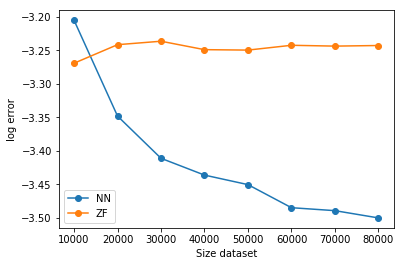

In [35]:
nn_acc = []
zeroforce_acc = []
for key in range(10000, 90000, 10000):
    avg_nn_acc = sum(avg_accuracies[key]) / len(avg_accuracies[key])
    zeroforce_accuracy = sum(zeroforce_avg_accuracy[key]) / len(zeroforce_avg_accuracy[key])
    nn_acc.append(avg_nn_acc)
    zeroforce_acc.append(zeroforce_accuracy)

    
plt.plot(range(10000, 90000, 10000),np.log(1 - np.array(nn_acc)), label='NN', marker='o')
plt.plot(range(10000, 90000, 10000), np.log(1 - np.array(zeroforce_acc)), label='ZF', marker='o')
plt.xlabel('Size dataset')
plt.ylabel('log error')
plt.legend()
plt.show()

In [18]:
avg_accuracies_SNR = {1: [0.7807125, 0.7806125, 0.7812416666666666, 0.7802791666666666, 0.779, 0.7797333333333333, 0.7789958333333333, 0.7814375, 0.7812875, 0.778425], 2: [0.8084458333333333, 0.8081666666666667, 0.8093541666666667, 0.80965, 0.8071208333333333, 0.8082041666666666, 0.8069458333333334, 0.8083125, 0.8090125, 0.8074916666666667], 3: [0.8364708333333334, 0.8366666666666667, 0.8364791666666667, 0.8343166666666667, 0.835725, 0.8358166666666667, 0.8362708333333333, 0.8354375, 0.8356583333333333, 0.8355083333333333], 4: [0.8616833333333334, 0.8613291666666667, 0.8621041666666667, 0.8611791666666667, 0.863, 0.8620791666666666, 0.8626041666666666, 0.8609291666666666, 0.8619083333333334, 0.8608208333333334], 5: [0.88585, 0.8863958333333334, 0.885925, 0.8858666666666667, 0.8861166666666667, 0.8868166666666667, 0.8866916666666667, 0.8854125, 0.8869541666666667, 0.8877291666666667], 6: [0.9084833333333333, 0.9089, 0.9076791666666667, 0.9096833333333333, 0.9101791666666667, 0.9093625, 0.9080333333333334, 0.9087916666666667, 0.9071833333333333, 0.9078916666666667], 7: [0.9283666666666667, 0.927425, 0.9270875, 0.9282458333333333, 0.9284, 0.9284125, 0.9281541666666666, 0.92765, 0.9275916666666667, 0.9263208333333334], 8: [0.9429791666666667, 0.9445583333333334, 0.9438375, 0.9438833333333333, 0.944325, 0.9436791666666666, 0.9437333333333333, 0.94455, 0.9430291666666667, 0.9423875], 9: [0.9569041666666667, 0.956875, 0.9567958333333333, 0.9568291666666666, 0.956475, 0.9561958333333334, 0.9564166666666667, 0.9571625, 0.9569083333333334, 0.9554416666666666], 10: [0.9674416666666666, 0.9658291666666666, 0.9683375, 0.9678875, 0.96665, 0.9664416666666666, 0.9674791666666667, 0.9674], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: []}

In [19]:
zeroforce_avg_accuracy_SNR = {}
for SNR in range(1, 20):
    zeroforce_avg_accuracy_SNR[SNR] = []
for SNR in range(11, 20):
    for trial in range(10):
        print('SNR', SNR)
        print('Trial', trial)
        preamble_length = 20
        data_length = 40
        channel_length = 2
        dataset_size = 30000
        X, Y = generate_combined_dataset(dataset_size, preamble_length, data_length, channel_length, SNR)

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        # print(X)
        # print(Y)
        preamble_X_train, preamble_X_test = X_train[:, :preamble_length * 2],  X_test[:, :preamble_length * 2]
        channel_Y_train, channel_Y_test = Y_train[:, :channel_length], Y_test[:, :channel_length]
        print(preamble_X_train.shape, preamble_X_test.shape)
        print(channel_Y_train.shape, channel_Y_test.shape)
        model_1 = create_model(300, 300, preamble_X_train.shape[1], channel_Y_train.shape[1])
        print('Fitting first model')
        model_1.fit(preamble_X_train, channel_Y_train, epochs=100, verbose=0)

        # predictions = model.predict(preamble_X_test)
        # from sklearn.metrics import mean_squared_error
        # from sklearn.metrics import mean_absolute_error
        # mse = mean_squared_error(predictions, channel_Y_test)
        # mabse = mean_absolute_error(predictions, channel_Y_test)
        # print('Mean Squared Error: {0}'.format(mse))
        # print('Mean Absolute Error: {0}'.format(mabse))
        channel_X_train = model_1.predict(preamble_X_train)
        channel_X_test = model_1.predict(preamble_X_test)
        data_convolved_X_train, data_convolved_X_test = X_train[:, preamble_length * 2:],  X_test[:, preamble_length * 2:]
        new_X_train = np.hstack([channel_X_train, data_convolved_X_train])
        new_X_test = np.hstack([channel_X_test, data_convolved_X_test])
        new_Y_train, new_Y_test = Y_train[:, channel_length:], Y_test[:, channel_length:]
        print(new_X_train.shape, new_X_test.shape, new_Y_train.shape, new_Y_train.shape)
        print('Fitting Second Model')
        model_2 = create_model(300, 300, new_X_train.shape[1], new_Y_train.shape[1])
        model_2.fit(new_X_train, new_Y_train, epochs=100, verbose=0)
        predictions = model_2.predict(new_X_test)
        rounded_predictions = np.where(predictions > 0, 1, -1)
        accuracy = calc_accuracy(new_Y_test, rounded_predictions)
        avg_accuracies_SNR[SNR].append(accuracy)
        print('NN accuracy', accuracy)
        zeroforce_accuracy = test_zf_accuracy(data_convolved_X_test, new_Y_test, channel_Y_test, data_length, channel_length)
        print('Zero Force accuracy', zeroforce_accuracy)
        zeroforce_avg_accuracy_SNR[SNR].append(zeroforce_accuracy)
print(avg_accuracies)
print(zeroforce_avg_accuracy)

SNR 11
Trial 0
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9737
(6000, 41)
Zero Force accuracy 0.9676208333333334
SNR 11
Trial 1
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9749791666666666
(6000, 41)
Zero Force accuracy 0.9709125
SNR 11
Trial 2
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9747666666666667
(6000, 41)
Zero Force accuracy 0.9706458333333333
SNR 11
Trial 3
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9732875
(6000, 41)
Zero Force accuracy 0.9687916666666667
SNR 11
Trial 4
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (240

(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.98815
(6000, 41)
Zero Force accuracy 0.9877375
SNR 14
Trial 8
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9889
(6000, 41)
Zero Force accuracy 0.9876041666666666
SNR 14
Trial 9
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9885708333333333
(6000, 41)
Zero Force accuracy 0.9881208333333333
SNR 15
Trial 0
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting Second Model
NN accuracy 0.9917666666666667
(6000, 41)
Zero Force accuracy 0.9920541666666667
SNR 15
Trial 1
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
Fitting first model
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
Fitting S

KeyboardInterrupt: 

In [38]:
print(avg_accuracies_SNR)

{1: [0.7807125, 0.7806125, 0.7812416666666666, 0.7802791666666666, 0.779, 0.7797333333333333, 0.7789958333333333, 0.7814375, 0.7812875, 0.778425], 2: [0.8084458333333333, 0.8081666666666667, 0.8093541666666667, 0.80965, 0.8071208333333333, 0.8082041666666666, 0.8069458333333334, 0.8083125, 0.8090125, 0.8074916666666667], 3: [0.8364708333333334, 0.8366666666666667, 0.8364791666666667, 0.8343166666666667, 0.835725, 0.8358166666666667, 0.8362708333333333, 0.8354375, 0.8356583333333333, 0.8355083333333333], 4: [0.8616833333333334, 0.8613291666666667, 0.8621041666666667, 0.8611791666666667, 0.863, 0.8620791666666666, 0.8626041666666666, 0.8609291666666666, 0.8619083333333334, 0.8608208333333334], 5: [0.88585, 0.8863958333333334, 0.885925, 0.8858666666666667, 0.8861166666666667, 0.8868166666666667, 0.8866916666666667, 0.8854125, 0.8869541666666667, 0.8877291666666667], 6: [0.9084833333333333, 0.9089, 0.9076791666666667, 0.9096833333333333, 0.9101791666666667, 0.9093625, 0.9080333333333334, 0

In [20]:
print(avg_accuracies_SNR)
print(zeroforce_avg_accuracy_SNR)

{1: [0.7807125, 0.7806125, 0.7812416666666666, 0.7802791666666666, 0.779, 0.7797333333333333, 0.7789958333333333, 0.7814375, 0.7812875, 0.778425], 2: [0.8084458333333333, 0.8081666666666667, 0.8093541666666667, 0.80965, 0.8071208333333333, 0.8082041666666666, 0.8069458333333334, 0.8083125, 0.8090125, 0.8074916666666667], 3: [0.8364708333333334, 0.8366666666666667, 0.8364791666666667, 0.8343166666666667, 0.835725, 0.8358166666666667, 0.8362708333333333, 0.8354375, 0.8356583333333333, 0.8355083333333333], 4: [0.8616833333333334, 0.8613291666666667, 0.8621041666666667, 0.8611791666666667, 0.863, 0.8620791666666666, 0.8626041666666666, 0.8609291666666666, 0.8619083333333334, 0.8608208333333334], 5: [0.88585, 0.8863958333333334, 0.885925, 0.8858666666666667, 0.8861166666666667, 0.8868166666666667, 0.8866916666666667, 0.8854125, 0.8869541666666667, 0.8877291666666667], 6: [0.9084833333333333, 0.9089, 0.9076791666666667, 0.9096833333333333, 0.9101791666666667, 0.9093625, 0.9080333333333334, 0

In [27]:
# zeroforce_avg_accuracy_SNR = {}
# for SNR in range(1, 20):
#     zeroforce_avg_accuracy_SNR[SNR] = []
for SNR in range(10, 11):
    for trial in range(10):
        print('SNR', SNR)
        print('Trial', trial)
        preamble_length = 20
        data_length = 40
        channel_length = 2
        dataset_size = 30000
        X, Y = generate_combined_dataset(dataset_size, preamble_length, data_length, channel_length, SNR)

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        # print(X)
        # print(Y)
        preamble_X_train, preamble_X_test = X_train[:, :preamble_length * 2],  X_test[:, :preamble_length * 2]
        channel_Y_train, channel_Y_test = Y_train[:, :channel_length], Y_test[:, :channel_length]
        print(preamble_X_train.shape, preamble_X_test.shape)
        print(channel_Y_train.shape, channel_Y_test.shape)
#         model_1 = create_model(300, 300, preamble_X_train.shape[1], channel_Y_train.shape[1])
#         print('Fitting first model')
#         model_1.fit(preamble_X_train, channel_Y_train, epochs=100, verbose=0)

        # predictions = model.predict(preamble_X_test)
        # from sklearn.metrics import mean_squared_error
        # from sklearn.metrics import mean_absolute_error
        # mse = mean_squared_error(predictions, channel_Y_test)
        # mabse = mean_absolute_error(predictions, channel_Y_test)
        # print('Mean Squared Error: {0}'.format(mse))
        # print('Mean Absolute Error: {0}'.format(mabse))
#         channel_X_train = model_1.predict(preamble_X_train)
#         channel_X_test = model_1.predict(preamble_X_test)
        data_convolved_X_train, data_convolved_X_test = X_train[:, preamble_length * 2:],  X_test[:, preamble_length * 2:]
        new_X_train = np.hstack([channel_X_train, data_convolved_X_train])
        new_X_test = np.hstack([channel_X_test, data_convolved_X_test])
        new_Y_train, new_Y_test = Y_train[:, channel_length:], Y_test[:, channel_length:]
        print(new_X_train.shape, new_X_test.shape, new_Y_train.shape, new_Y_train.shape)
#         print('Fitting Second Model')
#         model_2 = create_model(300, 300, new_X_train.shape[1], new_Y_train.shape[1])
#         model_2.fit(new_X_train, new_Y_train, epochs=100, verbose=0)
#         predictions = model_2.predict(new_X_test)
#         rounded_predictions = np.where(predictions > 0, 1, -1)
#         accuracy = calc_accuracy(new_Y_test, rounded_predictions)
#         avg_accuracies_SNR[SNR].append(accuracy)
#         print('NN accuracy', accuracy)
        zeroforce_accuracy = test_zf_accuracy(data_convolved_X_test, new_Y_test, channel_Y_test, data_length, channel_length)
        print('Zero Force accuracy', zeroforce_accuracy)
        zeroforce_avg_accuracy_SNR[SNR].append(zeroforce_accuracy)
print(avg_accuracies)
print(zeroforce_avg_accuracy)

SNR 10
Trial 0
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
(6000, 41)
Zero Force accuracy 0.9603625
SNR 10
Trial 1
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
(6000, 41)
Zero Force accuracy 0.9615083333333333
SNR 10
Trial 2
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
(6000, 41)
Zero Force accuracy 0.9593125
SNR 10
Trial 3
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
(6000, 41)
Zero Force accuracy 0.9597291666666666
SNR 10
Trial 4
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
(6000, 41)
Zero Force accuracy 0.9606666666666667
SNR 10
Trial 5
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) (24000, 40) (24000, 40)
(6000, 41)
Zero Force accuracy 0.9651416666666667
SNR 10
Trial 6
(24000, 40) (6000, 40)
(24000, 2) (6000, 2)
(24000, 43) (6000, 43) 

NameError: name 'avg_accuracies' is not defined

In [28]:
print(avg_accuracies_SNR)
print(zeroforce_avg_accuracy_SNR)

{1: [0.7807125, 0.7806125, 0.7812416666666666, 0.7802791666666666, 0.779, 0.7797333333333333, 0.7789958333333333, 0.7814375, 0.7812875, 0.778425], 2: [0.8084458333333333, 0.8081666666666667, 0.8093541666666667, 0.80965, 0.8071208333333333, 0.8082041666666666, 0.8069458333333334, 0.8083125, 0.8090125, 0.8074916666666667], 3: [0.8364708333333334, 0.8366666666666667, 0.8364791666666667, 0.8343166666666667, 0.835725, 0.8358166666666667, 0.8362708333333333, 0.8354375, 0.8356583333333333, 0.8355083333333333], 4: [0.8616833333333334, 0.8613291666666667, 0.8621041666666667, 0.8611791666666667, 0.863, 0.8620791666666666, 0.8626041666666666, 0.8609291666666666, 0.8619083333333334, 0.8608208333333334], 5: [0.88585, 0.8863958333333334, 0.885925, 0.8858666666666667, 0.8861166666666667, 0.8868166666666667, 0.8866916666666667, 0.8854125, 0.8869541666666667, 0.8877291666666667], 6: [0.9084833333333333, 0.9089, 0.9076791666666667, 0.9096833333333333, 0.9101791666666667, 0.9093625, 0.9080333333333334, 0

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


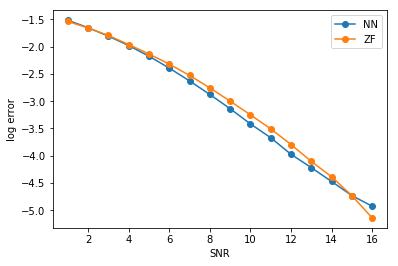

In [30]:
nn_acc_SNR = []
zeroforce_acc_SNR = []
for key in range(1, 17):
    print(key)
    avg_nn_acc = sum(avg_accuracies_SNR[key]) / len(avg_accuracies_SNR[key])
    zeroforce_accuracy = sum(zeroforce_avg_accuracy_SNR[key]) / len(zeroforce_avg_accuracy_SNR[key])
    nn_acc_SNR.append(avg_nn_acc)
    zeroforce_acc_SNR.append(zeroforce_accuracy)

    
plt.plot(range(1, 17),np.log(1 - np.array(nn_acc_SNR)), label='NN', marker='o')
plt.plot(range(1, 17), np.log(1 - np.array(zeroforce_acc_SNR)), label='ZF', marker='o')
plt.xlabel('SNR')
plt.ylabel('log error')
plt.legend()
plt.show()

In [75]:
def create_end_to_end_model(input_layer_dim, hidden_layer_dim, input_dim, output_dim, data_length, channel_length):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(hidden_layer_dim, activation='sigmoid'))
    model.add(Dense(data_length + channel_length, activation='sigmoid'))
    model.add(Dense(hidden_layer_dim, activation='sigmoid'))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
dataset_size = 1000000
preamble_length = 20
data_length = 40
channel_length = 2
SNR = 10
X, Y = generate_data_set(dataset_size, preamble_length, data_length, channel_length, SNR)
Y = (Y + 1) / 2
print(Y)
# print(X.shape)


[[0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 1. 1.]
 [1. 0. 1. ... 1. 1. 0.]]


In [76]:
model = create_end_to_end_model(300, 300, X.shape[1], Y.shape[1], data_length, channel_length)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
model.fit(X_train, Y_train, epochs=300)
predictions = model.predict(X_test)


Epoch 1/300
800000/800000 [==============================] - 112s - loss: 0.3873 - acc: 0.8047   
Epoch 2/300
800000/800000 [==============================] - 110s - loss: 0.2381 - acc: 0.8917   
Epoch 3/300
800000/800000 [==============================] - 110s - loss: 0.1835 - acc: 0.9208   
Epoch 4/300
800000/800000 [==============================] - 110s - loss: 0.1443 - acc: 0.9398   
Epoch 5/300
800000/800000 [==============================] - 110s - loss: 0.1035 - acc: 0.9587   
Epoch 6/300
800000/800000 [==============================] - 110s - loss: 0.0807 - acc: 0.9687   
Epoch 7/300
800000/800000 [==============================] - 110s - loss: 0.0658 - acc: 0.9750   
Epoch 8/300
800000/800000 [==============================] - 111s - loss: 0.0570 - acc: 0.9786   
Epoch 9/300
800000/800000 [==============================] - 110s - loss: 0.0492 - acc: 0.9818   
Epoch 10/300
800000/800000 [==============================] - 110s - loss: 0.0445 - acc: 0.9837   
Epoch 11/300
800000

800000/800000 [==============================] - 110s - loss: 0.0172 - acc: 0.9940   
Epoch 84/300
800000/800000 [==============================] - 110s - loss: 0.0171 - acc: 0.9941   
Epoch 85/300
800000/800000 [==============================] - 111s - loss: 0.0171 - acc: 0.9941   
Epoch 86/300
800000/800000 [==============================] - 110s - loss: 0.0170 - acc: 0.9941   
Epoch 87/300
800000/800000 [==============================] - 110s - loss: 0.0170 - acc: 0.9941   
Epoch 88/300
800000/800000 [==============================] - 111s - loss: 0.0169 - acc: 0.9941   
Epoch 89/300
800000/800000 [==============================] - 112s - loss: 0.0169 - acc: 0.9941   
Epoch 90/300
800000/800000 [==============================] - 110s - loss: 0.0169 - acc: 0.9941   
Epoch 91/300
800000/800000 [==============================] - 110s - loss: 0.0168 - acc: 0.9942   
Epoch 92/300
800000/800000 [==============================] - 111s - loss: 0.0168 - acc: 0.9941   
Epoch 93/300
800000/800

800000/800000 [==============================] - 111s - loss: 0.0154 - acc: 0.9946   
Epoch 166/300
800000/800000 [==============================] - 110s - loss: 0.0154 - acc: 0.9946   
Epoch 167/300
800000/800000 [==============================] - 111s - loss: 0.0154 - acc: 0.9946   
Epoch 168/300
800000/800000 [==============================] - 111s - loss: 0.0154 - acc: 0.9946   
Epoch 169/300
800000/800000 [==============================] - 110s - loss: 0.0153 - acc: 0.9946   
Epoch 170/300
800000/800000 [==============================] - 111s - loss: 0.0153 - acc: 0.9946   
Epoch 171/300
800000/800000 [==============================] - 111s - loss: 0.0153 - acc: 0.9946   
Epoch 172/300
800000/800000 [==============================] - 111s - loss: 0.0153 - acc: 0.9946   
Epoch 173/300
800000/800000 [==============================] - 111s - loss: 0.0153 - acc: 0.9946   
Epoch 174/300
800000/800000 [==============================] - 111s - loss: 0.0153 - acc: 0.9946   
Epoch 175/300


800000/800000 [==============================] - 110s - loss: 0.0147 - acc: 0.9948   
Epoch 248/300
800000/800000 [==============================] - 111s - loss: 0.0147 - acc: 0.9948   
Epoch 249/300
800000/800000 [==============================] - 110s - loss: 0.0147 - acc: 0.9948   
Epoch 250/300
800000/800000 [==============================] - 111s - loss: 0.0147 - acc: 0.9948   
Epoch 251/300
800000/800000 [==============================] - 111s - loss: 0.0146 - acc: 0.9948   
Epoch 252/300
800000/800000 [==============================] - 111s - loss: 0.0147 - acc: 0.9948   
Epoch 253/300
800000/800000 [==============================] - 110s - loss: 0.0147 - acc: 0.9948   
Epoch 254/300
800000/800000 [==============================] - 111s - loss: 0.0146 - acc: 0.9948   
Epoch 255/300
800000/800000 [==============================] - 111s - loss: 0.0146 - acc: 0.9948   
Epoch 256/300
800000/800000 [==============================] - 111s - loss: 0.0146 - acc: 0.9948   
Epoch 257/300


In [77]:
rounded_predictions = np.where(predictions > 0.5, 1, 0)

In [81]:
mean_squared_error((Y_test * 2) - 1, (predictions * 2) - 1)

0.02326783504366672

In [78]:
calc_accuracy(rounded_predictions, Y_test)

0.99251675

In [ ]:
test_zf_accuracy()

In [89]:
def create_end_to_end_model_mse(input_layer_dim, hidden_layer_dim, input_dim, output_dim, data_length, channel_length):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden_layer_dim, activation='relu'))
    model.add(Dense(data_length + channel_length, activation='relu'))
    model.add(Dense(hidden_layer_dim, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [90]:
def generate_data_set_equal(dataset_size, preamble_length, data_length, channel_length, SNR):
    input_data_bits = np.random.randint(0,2,(dataset_size, data_length)) 
    orig_input_data_constellations = input_data_bits * 2 - 1
    noise = np.random.normal(0, 0.1, orig_input_data_constellations.shape)
    input_data_constellations = orig_input_data_constellations + noise
    preambles = np.random.randint(0, 2, (dataset_size, preamble_length))
    convolved_preambles = []
    convolved_data_constellations = []
    
    for i in range(dataset_size):
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps)>=1:
            channel_taps = channel_taps / sum(channel_taps)
        preamble_conv = add_awgn_noise(sig.convolve(preambles[i], channel_taps, mode='same'), SNR)
        convolved_preambles.append(preamble_conv)
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellations[i], channel_taps, mode='same'), SNR)
        convolved_data_constellations.append(constellation_convolved)
    X = np.hstack([preambles, np.array(convolved_preambles), np.array(convolved_data_constellations)])
    Y = input_data_constellations
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X, Y

In [91]:
X, Y = generate_data_set_equal(dataset_size, preamble_length, data_length, channel_length, SNR)

In [92]:
model = create_end_to_end_model_mse(300, 300, X.shape[1], Y.shape[1], data_length, channel_length)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))
predictions = model.predict(X_test)


Train on 800000 samples, validate on 200000 samples
Epoch 1/100
800000/800000 [==============================] - 142s - loss: 0.4169 - mean_squared_error: 0.4169 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 2/100
800000/800000 [==============================] - 134s - loss: 0.2471 - mean_squared_error: 0.2471 - val_loss: 0.1909 - val_mean_squared_error: 0.1909
Epoch 3/100
800000/800000 [==============================] - 137s - loss: 0.1653 - mean_squared_error: 0.1653 - val_loss: 0.1467 - val_mean_squared_error: 0.1467
Epoch 4/100
800000/800000 [==============================] - 135s - loss: 0.1358 - mean_squared_error: 0.1358 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 5/100
800000/800000 [==============================] - 131s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1146 - val_mean_squared_error: 0.1146
Epoch 6/100
800000/800000 [==============================] - 133s - loss: 0.1140 - mean_squared_error: 0.1140 - val_loss: 0.1093 - val_mea

800000/800000 [==============================] - 119s - loss: 0.0839 - mean_squared_error: 0.0839 - val_loss: 0.0873 - val_mean_squared_error: 0.0873
Epoch 51/100
800000/800000 [==============================] - 119s - loss: 0.0835 - mean_squared_error: 0.0835 - val_loss: 0.0829 - val_mean_squared_error: 0.0829
Epoch 52/100
800000/800000 [==============================] - 119s - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0847 - val_mean_squared_error: 0.0847
Epoch 53/100
800000/800000 [==============================] - 119s - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0862 - val_mean_squared_error: 0.0862
Epoch 54/100
800000/800000 [==============================] - 126s - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 0.0861 - val_mean_squared_error: 0.0861
Epoch 55/100
800000/800000 [==============================] - 134s - loss: 0.0829 - mean_squared_error: 0.0829 - val_loss: 0.0843 - val_mean_squared_error: 0.0843
Epoch 56/100
800000/800000 [=======

800000/800000 [==============================] - 126s - loss: 0.0793 - mean_squared_error: 0.0793 - val_loss: 0.0823 - val_mean_squared_error: 0.0823


In [95]:
# print(Y_test)
rounded_predictions = np.where(predictions > 0, 1, -1)
Y_test_rounded = np.where(Y_test > 0, 1, -1)
calc_accuracy(rounded_predictions, Y_test_rounded)

0.98149675

In [99]:
import commpy as cp
def generate_combined_dataset_qam_4(dataset_size,  preamble_length, data_length, channel_length, SNR, constellations):
    QAMModem = cp.modulation.QAMModem(constellations)
    
    # use the constellation object to modulate the data bits into complex numbers
    
    
    preambles_constellations = []
    input_data_constellations = []
    convolved_preambles = []
    convolved_data_constellations = []
    
    for i in range(dataset_size):
        input_data_bits = np.random.randint(0, 2, data_length)
        preambles = np.random.randint(0, 2, preamble_length)
        
        input_data_constellation = QAMModem.modulate(input_data_bits)
        real_input = np.real(input_data_constellation)
        im_input = np.imag(input_data_constellation)
        real_im_input = np.vstack((real_input,im_input)).reshape((-1,),order='F')
        input_data_constellations.append(real_im_input)
        
        preambles_constellation =  QAMModem.modulate(preambles)
        real_preambles = np.real(preambles_constellation)
        im_preambles = np.imag(preambles_constellation)
        real_im_preambles = np.vstack((real_preambles,im_preambles)).reshape((-1,),order='F')
        preambles_constellations.append(real_im_preambles)
        
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps) >= 1:
            channel_taps = channel_taps / sum(channel_taps)
        preamble_conv = sig.convolve(preambles_constellation, channel_taps, mode='same')
        real_preambles_conv = np.real(preamble_conv)
        im_preambles_conv = np.imag(preamble_conv)
        real_im_preambles_conv = np.vstack((real_preambles_conv,im_preambles_conv)).reshape((-1,),order='F')
        convolved_preambles.append(real_im_preambles_conv)
        
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellation, channel_taps, mode='same'), SNR)
        real_constellation_conv = np.real(constellation_convolved)
        im_constellation_conv = np.imag(constellation_convolved)
        real_im_constellation_conv = np.vstack((real_constellation_conv,im_constellation_conv)).reshape((-1,),order='F')
        convolved_data_constellations.append(real_im_constellation_conv)
        
    X1 = np.hstack([preambles_constellations, np.array(convolved_preambles), np.array(convolved_data_constellations)])
    Y = np.array(input_data_constellations)
#     plt.scatter(np.zeros(input_data_constellations.shape[1]), input_data_constellations[0])
#     plt.show()
    return X1, Y

In [101]:
X, Y = generate_combined_dataset_qam_4(1000000, 20, 40, 2, 10, 16)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
# model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))
# predictions = model.predict(X_test)

(800000, 40) (800000, 20)
(200000, 40) (200000, 20)


In [103]:
model = create_end_to_end_model_mse(300, 300, X.shape[1], Y.shape[1], 40, 2)
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))
predictions = model.predict(X_test)

Train on 800000 samples, validate on 200000 samples
Epoch 1/100
800000/800000 [==============================] - 126s - loss: 1.1419 - mean_squared_error: 1.1419 - val_loss: 0.9330 - val_mean_squared_error: 0.9330
Epoch 2/100
800000/800000 [==============================] - 127s - loss: 0.9093 - mean_squared_error: 0.9093 - val_loss: 0.8912 - val_mean_squared_error: 0.8912
Epoch 3/100
800000/800000 [==============================] - 123s - loss: 0.8793 - mean_squared_error: 0.8793 - val_loss: 0.8643 - val_mean_squared_error: 0.8643
Epoch 4/100
800000/800000 [==============================] - 129s - loss: 0.8652 - mean_squared_error: 0.8652 - val_loss: 0.8626 - val_mean_squared_error: 0.8626
Epoch 5/100
800000/800000 [==============================] - 125s - loss: 0.8556 - mean_squared_error: 0.8556 - val_loss: 0.8592 - val_mean_squared_error: 0.8592
Epoch 6/100
800000/800000 [==============================] - 131s - loss: 0.8488 - mean_squared_error: 0.8488 - val_loss: 0.8402 - val_mea

800000/800000 [==============================] - 129s - loss: 0.8059 - mean_squared_error: 0.8059 - val_loss: 0.8073 - val_mean_squared_error: 0.8073
Epoch 52/100
800000/800000 [==============================] - 127s - loss: 0.8056 - mean_squared_error: 0.8056 - val_loss: 0.8093 - val_mean_squared_error: 0.8093
Epoch 53/100
800000/800000 [==============================] - 134s - loss: 0.8055 - mean_squared_error: 0.8055 - val_loss: 0.8119 - val_mean_squared_error: 0.8119
Epoch 54/100
800000/800000 [==============================] - 132s - loss: 0.8054 - mean_squared_error: 0.8054 - val_loss: 0.8044 - val_mean_squared_error: 0.8044
Epoch 55/100
800000/800000 [==============================] - 126s - loss: 0.8046 - mean_squared_error: 0.8046 - val_loss: 0.8096 - val_mean_squared_error: 0.8096
Epoch 56/100
800000/800000 [==============================] - 126s - loss: 0.8044 - mean_squared_error: 0.8044 - val_loss: 0.8099 - val_mean_squared_error: 0.8099
Epoch 57/100
800000/800000 [=======

In [104]:
def convert_to_class(predictions):
    class_predictions = np.zeros((predictions.shape[0], predictions.shape[1]))
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            elem = predictions[i][j]
            if elem > 2:
                class_predictions[i][j] = 3
            elif elem > 0:
                class_predictions[i][j] = 1
            elif elem > -2:
                class_predictions[i][j] = -1
            else:
                class_predictions[i][j] = -3
    return class_predictions

class_predictions = convert_to_class(predictions)

In [106]:
print(class_predictions)
Y_test

[[-3. -1.  3. ...  3.  3. -1.]
 [-1.  1. -3. ...  3.  3.  1.]
 [ 1. -3.  1. ... -1. -3. -1.]
 ...
 [-1.  3. -1. ... -1.  1.  1.]
 [ 1. -3.  3. ... -1. -3. -1.]
 [ 1. -3.  1. ... -1. -3.  1.]]


array([[-3., -1.,  3., ...,  3.,  3., -1.],
       [-1.,  1., -3., ...,  3.,  3., -1.],
       [-1., -3.,  3., ..., -1., -3., -1.],
       ...,
       [-1.,  1., -1., ..., -1.,  1.,  3.],
       [ 1., -1.,  3., ..., -1., -1., -3.],
       [-1., -3.,  3., ..., -1., -3.,  1.]])

In [107]:
calc_accuracy(class_predictions, Y_test)

0.7723265

In [86]:
def generate_channel_data_set_noise(dataset_size, data_length, channel_length, SNR):
    input_data_bits = np.random.randint(0,2,(dataset_size, data_length)) 
    orig_input_data_constellations = input_data_bits * 2 - 1
    noise = np.random.normal(0, 0.1, orig_input_data_constellations.shape)
#     noise = 0
    input_data_constellations = orig_input_data_constellations + noise
    convolved_data_constellations = []
    channels= []
    
    for i in range(dataset_size):
        channel_taps = np.random.uniform(0,1,channel_length)
        if sum(channel_taps)>=1:
            channel_taps = channel_taps / sum(channel_taps)
        channels.append(channel_taps)
        constellation_convolved = add_awgn_noise(sig.convolve(input_data_constellations[i], channel_taps, mode='same'), SNR)
        convolved_data_constellations.append(constellation_convolved)
    X = np.hstack([np.array(channels), np.array(convolved_data_constellations)])
    Y = input_data_constellations
    return X, Y

X, Y = generate_channel_data_set_noise(1000000, 80, 2, 10)

print(X.shape, Y.shape)
print(X)
print(Y)
def create_model_channel(input_layer_dim, hidden_layer_dim, input_dim, output_dim):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden_layer_dim, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
model = create_model_channel(300, 300, X_train.shape[1], Y_train.shape[1])
model.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

(1000000, 82) (1000000, 80)
[[ 0.58510367  0.27991328  0.6990543  ...  0.63497462  0.83208688
   0.71619867]
 [ 0.377737    0.622263   -0.46781764 ...  1.38120405  0.99868608
   0.64274304]
 [ 0.69829844  0.30170156  0.73131857 ... -0.00832878 -0.86258825
  -1.23054454]
 ...
 [ 0.64788962  0.03211591 -0.95232911 ... -0.60684815  0.63445482
  -0.50402474]
 [ 0.36509102  0.63490898  0.37701816 ... -1.27908754 -1.20342509
  -0.2966609 ]
 [ 0.61860753  0.38139247  0.87333623 ... -1.05399182  0.31911646
   0.4181788 ]]
[[ 1.0457358  -0.82488697  0.93957313 ...  0.94173252  0.99020137
   0.91457268]
 [-1.00228004  0.95907844 -1.08495527 ...  0.97244609  1.07311545
  -0.90530487]
 [ 0.81306578  1.03109152 -1.05824808 ... -1.00051518 -1.04101842
  -1.06215571]
 ...
 [-0.91371751 -0.81738698 -1.05443542 ... -0.89855549  1.06235014
  -0.95620143]
 [ 1.17281214  1.011111   -0.99881102 ... -1.10124419 -1.22408167
   0.93205307]
 [ 1.02925093 -0.91499863 -0.95087766 ... -1.04681055  0.91293204
   0

800000/800000 [==============================] - 119s - loss: 0.0773 - mean_squared_error: 0.0773 - val_loss: 0.0777 - val_mean_squared_error: 0.0777
Epoch 45/100
800000/800000 [==============================] - 118s - loss: 0.0772 - mean_squared_error: 0.0772 - val_loss: 0.0773 - val_mean_squared_error: 0.0773
Epoch 46/100
800000/800000 [==============================] - 117s - loss: 0.0770 - mean_squared_error: 0.0770 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 47/100
800000/800000 [==============================] - 118s - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.0766 - val_mean_squared_error: 0.0766
Epoch 48/100
800000/800000 [==============================] - 115s - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 49/100
800000/800000 [==============================] - 119s - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.0767 - val_mean_squared_error: 0.0767
Epoch 50/100
800000/800000 [=======

800000/800000 [==============================] - 107s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 95/100
800000/800000 [==============================] - 118s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0758 - val_mean_squared_error: 0.0758
Epoch 96/100
800000/800000 [==============================] - 118s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0760 - val_mean_squared_error: 0.0760
Epoch 97/100
800000/800000 [==============================] - 124s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0753 - val_mean_squared_error: 0.0753
Epoch 98/100
800000/800000 [==============================] - 123s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 99/100
800000/800000 [==============================] - 120s - loss: 0.0756 - mean_squared_error: 0.0756 - val_loss: 0.0765 - val_mean_squared_error: 0.0765
Epoch 100/100
800000/800000 [======

In [87]:
Y_test

array([[ 0.99905435, -0.94742967,  1.03344634, ...,  0.81244934,
         0.93319476, -1.00454789],
       [ 1.06305385,  1.07217184,  1.0943496 , ..., -1.06118516,
         0.94746957, -0.90838987],
       [ 0.9532574 ,  0.99904465,  0.9737466 , ..., -0.89300743,
        -1.12426887, -1.06055373],
       ...,
       [ 1.0556749 , -1.25187042,  1.01688018, ..., -0.98736371,
        -1.12501909,  1.02163349],
       [-1.09924976,  1.13468543, -0.90543492, ...,  1.03334248,
         1.03980909,  0.92940934],
       [ 1.06156287, -0.93012383,  1.02566621, ...,  0.97234898,
         0.98817978,  0.98679479]])

In [88]:
model.predict(X_test)

array([[ 1.0248083 , -1.1096332 ,  0.67372817, ...,  0.9441439 ,
         1.2120521 , -0.7651621 ],
       [ 1.1253104 ,  0.74559355,  1.1236753 , ..., -1.1236415 ,
         1.2498152 , -0.7722392 ],
       [ 1.1139121 ,  0.7753333 ,  1.1115692 , ..., -1.1459732 ,
        -0.9868889 , -0.6038163 ],
       ...,
       [ 1.0229745 , -1.0331888 ,  1.0730779 , ..., -0.8623979 ,
        -0.9004607 ,  1.0323029 ],
       [-1.0327303 ,  0.85857   , -0.94071835, ...,  1.151061  ,
         1.0192033 ,  0.88029015],
       [ 0.9582402 , -1.0864005 ,  0.93315023, ...,  0.98341596,
         0.85102725,  0.8240269 ]], dtype=float32)

In [82]:
Y_test

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 1.]])